In [382]:
import pandas as pd
import numpy as np
from datetime import datetime

In [396]:
waiting_times = pd.read_csv("final_data/data_pp_merged.csv")

# Encoding data

In [397]:
waiting_times["date"] = pd.to_datetime(waiting_times["date"])

In [ ]:
# Create a continuous time feature
waiting_times["time_encoded"] = waiting_times["hour"] * 4 + waiting_times["minute"] / 15

# Cyclical encoding for day of week
waiting_times["day_of_week"] = waiting_times["date"].dt.dayofweek
waiting_times["day_of_week_sin"] = np.sin(
    2 * np.pi * waiting_times["day_of_week"] / 7
)
waiting_times["day_of_week_cos"] = np.cos(
    2 * np.pi * waiting_times["day_of_week"] / 7
)


waiting_times["year"] = waiting_times["date"].dt.year
waiting_times["month"] = waiting_times["date"].dt.month
waiting_times["day"] = waiting_times["date"].dt.day

# Cyclical encoding for month of year
waiting_times["month_sin"] = np.sin(2 * np.pi * (waiting_times["month"] - 1) / 12)
waiting_times["month_cos"] = np.cos(2 * np.pi * (waiting_times["month"] - 1) / 12)

# Cyclical encoding for day of month
waiting_times["day_sin"] = np.sin(2 * np.pi * (waiting_times["day"] - 1) / 31)
waiting_times["day_cos"] = np.cos(2 * np.pi * (waiting_times["day"] - 1) / 31)

# Year as one-hot encoding
waiting_times = pd.get_dummies(waiting_times, columns=["year"])

# Remove original columns used for encoding
waiting_times.drop(columns=["hour", "minute", "day_of_week", "month", "day"], inplace=True)

# One-hot encoding for ride names
ride_names = waiting_times["ENTITY_DESCRIPTION_SHORT"].unique()
ride_names_encoded = pd.get_dummies(waiting_times["ENTITY_DESCRIPTION_SHORT"])
waiting_times = pd.concat([waiting_times, ride_names_encoded], axis=1)

# Remove rows with downtime & drop ununsed columns

In [399]:
# Only keep rows without downtime
waiting_times = waiting_times[waiting_times["DOWNTIME"] == 0]

# Drop columns not useful for the ML model
cols_to_drop = [
    "WORK_DATE",
    "FIN_TIME",
    "NB_UNITS",
    "GUEST_CARRIED",
    "NB_MAX_UNIT",
    "ADJUST_CAPACITY",
    "OPEN_TIME",
    "UP_TIME",
    "CAPACITY",
    "DOWNTIME",
    "ENTITY_DESCRIPTION_SHORT",
    "DEB_TIME",
    "DEB_TIME_HOUR",
    "FACILITY_NAME",
    "date"
]
waiting_times.drop(
    columns=[c for c in cols_to_drop if c in waiting_times.columns],
    inplace=True
)

# Remove outliers

In [400]:
# Calculate the first (Q1) and third quartiles (Q3)
Q1 = waiting_times["WAIT_TIME_MAX"].quantile(0.25)
Q3 = waiting_times["WAIT_TIME_MAX"].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for non-outlier values
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to keep only rows within the bounds
waiting_times = waiting_times[
    (waiting_times["WAIT_TIME_MAX"] >= lower_bound) & 
    (waiting_times["WAIT_TIME_MAX"] <= upper_bound)
]

# Log-transform target variable

In [401]:
waiting_times["WAIT_TIME_MAX"] = np.log1p(waiting_times["WAIT_TIME_MAX"])

In [402]:
print("Preprocessing complete. Final shape:", waiting_times.shape)
waiting_times.head()

Preprocessing complete. Final shape: (1103831, 50)


,WAIT_TIME_MAX,temp,humidity,wind_speed,clouds_all,rain_1h,snow_1h,attendance,in_night_show,in_parade_1,...,Oz Theatre,Rapids Ride,Roller Coaster,Spinning Coaster,Spiral Slide,Superman Ride,Swing Ride,Vertical Drop,Water Ride,Zipline
0,2.772589,15.68,54,6.44,93,0.0,0.0,25133.0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1.791759,10.94,75,5.49,7,0.0,0.0,25133.0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1.791759,10.94,75,5.49,7,0.0,0.0,25133.0,False,False,...,False,False,False,False,False,False,False,False,False,False
5,3.433987,15.30,50,5.99,46,0.0,0.0,25133.0,False,False,...,False,False,False,False,False,False,False,False,False,False
6,3.713572,11.13,59,4.58,21,0.0,0.0,25133.0,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
waiting_times

Index(['WAIT_TIME_MAX', 'temp', 'humidity', 'wind_speed', 'clouds_all',
       'rain_1h', 'snow_1h', 'attendance', 'in_night_show', 'in_parade_1',
       'in_parade_2', 'covid', 'time_encoded', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'year_2018', 'year_2019', 'year_2020', 'year_2021', 'year_2022',
       'Bumper Cars', 'Bungee Jump', 'Circus Train', 'Crazy Dance',
       'Dizzy Dropper', 'Drop Tower', 'Flying Coaster', 'Free Fall',
       'Giant Wheel', 'Giga Coaster', 'Go-Karts', 'Haunted House',
       'Himalaya Ride', 'Inverted Coaster', 'Kiddie Coaster', 'Merry Go Round',
       'Oz Theatre', 'Rapids Ride', 'Roller Coaster', 'Spinning Coaster',
       'Spiral Slide', 'Superman Ride', 'Swing Ride', 'Vertical Drop',
       'Water Ride', 'Zipline'],
      dtype='object')

# Model

In [390]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# Train/Test split
train_df, test_df = train_test_split(waiting_times, test_size=0.2, random_state=42)

# Separate features and target
X_train = train_df.drop(columns=["WAIT_TIME_MAX"])
y_train = train_df["WAIT_TIME_MAX"]

X_test = test_df.drop(columns=["WAIT_TIME_MAX"])
y_test = test_df["WAIT_TIME_MAX"]


In [ ]:
X_train

In [391]:
# Define pipeline
pipeline = Pipeline([
    ("select_k_best", SelectKBest(score_func=f_regression, k=10)),
    ("xgb_regressor", XGBRegressor(random_state=42))
])

param_distributions = {
    "select_k_best__k": [45, 47, 48, 49],
    "xgb_regressor__n_estimators": [500, 750, 1000, 1500],
    "xgb_regressor__learning_rate": [0.075, 0.1, 0.2],
    "xgb_regressor__max_depth": [5, 8, 10, 12],
    "xgb_regressor__subsample": [0.6, 0.8, 1.0],
    "xgb_regressor__gamma": [0, 0.05, 0.1, 0.3, 1.0],
    "xgb_regressor__colsample_bytree": [0.6, 0.8, 1.0],
    "xgb_regressor__reg_alpha": [0, 0.1, 1, 10],
    "xgb_regressor__reg_lambda": [0, 0.1, 1, 10],
    "xgb_regressor__min_child_weight": [5, 10, 20]}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=4,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)


print("Best hyperparameters:", random_search.best_params_)
print("Best CV score (neg MSE):", random_search.best_score_)



Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best hyperparameters: {'xgb_regressor__subsample': 0.6, 'xgb_regressor__reg_lambda': 1, 'xgb_regressor__reg_alpha': 1, 'xgb_regressor__n_estimators': 750, 'xgb_regressor__min_child_weight': 5, 'xgb_regressor__max_depth': 12, 'xgb_regressor__learning_rate': 0.2, 'xgb_regressor__gamma': 0.1, 'xgb_regressor__colsample_bytree': 0.8, 'select_k_best__k': 49}
Best CV score (neg MSE): -0.11025914757828244


In [392]:
best_pipeline = random_search.best_estimator_

y_pred = best_pipeline.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", test_rmse)

Test RMSE: 0.3135421641307607


In [394]:
from sklearn.metrics import r2_score, mean_squared_error

# Revert the logarithmic transformation
y_test_reverted = np.expm1(y_test)
y_pred_reverted = np.expm1(y_pred)

# Round predictions UP to the next multiple of 5
y_pred_rounded = np.ceil(y_pred_reverted / 5) * 5

# Compute overall R² and RMSE on the original scale
r2_overall = r2_score(y_test_reverted, y_pred_rounded)
rmse_overall = np.sqrt(mean_squared_error(y_test_reverted, y_pred_rounded))

print("Overall R²:", r2_overall)
print("Overall RMSE:", rmse_overall)

Overall R²: 0.8833967056424417
Overall RMSE: 7.480052216200823


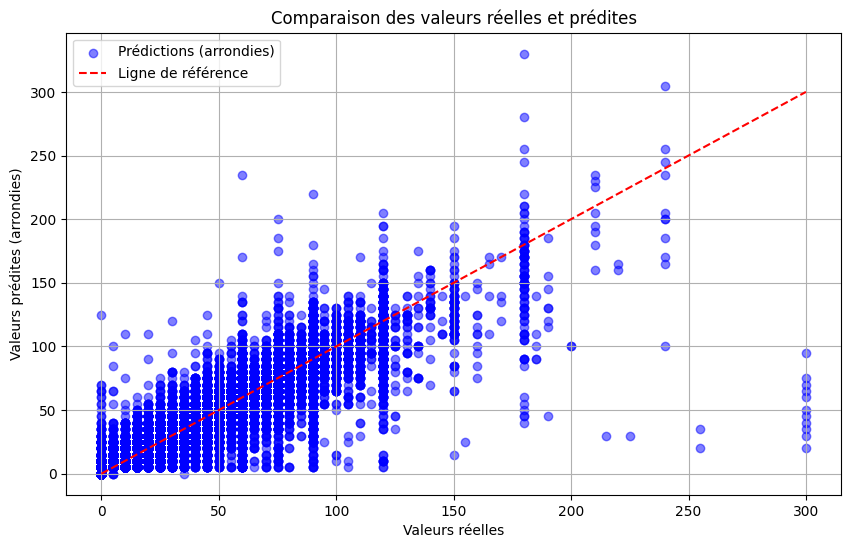

In [395]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reverted, y_pred_rounded, color='blue', alpha=0.5, label='Prédictions (arrondies)')
plt.plot(
    [min(y_test_reverted), max(y_test_reverted)],
    [min(y_test_reverted), max(y_test_reverted)],
    color='red',
    linestyle='--',
    label='Ligne de référence'
)
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites (arrondies)')
plt.title('Comparaison des valeurs réelles et prédites')
plt.legend()
plt.grid(True)
plt.show()


# One model per ride

In [346]:
df = waiting_times

In [377]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 1) List of ride columns (one-hot encoded in df)
ride_columns = [
    'Bumper Cars', 'Bungee Jump', 'Circus Train', 'Crazy Dance',
    'Dizzy Dropper', 'Drop Tower', 'Flying Coaster', 'Free Fall',
    'Giant Wheel', 'Giga Coaster', 'Go-Karts', 'Haunted House',
    'Himalaya Ride', 'Inverted Coaster', 'Kiddie Coaster', 'Merry Go Round',
    'Oz Theatre', 'Rapids Ride', 'Roller Coaster', 'Spinning Coaster',
    'Spiral Slide', 'Superman Ride', 'Swing Ride', 'Vertical Drop',
    'Water Ride', 'Zipline'
]

# 2) Dictionary to store one model per ride
models_per_ride = {}

# 3) Dictionary to store predictions in original scale for each ride
predictions_dict = {}

# ------------------------------------------------------------------------
# TRAINING LOOP
# ------------------------------------------------------------------------
for ride in ride_columns:
    df_ride = df[df[ride] == 1].copy()
    
    if len(df_ride) < 50:
        print(f"Skipping {ride}: not enough data ({len(df_ride)} rows).")
        continue
    
    # We'll predict WAIT_TIME_MAX (assumed log1p-transformed)
    y = df_ride["WAIT_TIME_MAX"]
    X = df_ride.drop(columns=["WAIT_TIME_MAX"] + ride_columns, errors="ignore")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.2,
        max_depth=12,
        random_state=42
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    
    y_pred_log = model.predict(X_test)
    r2_log = r2_score(y_test, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
    print(f"{ride} -> R^2 (log): {r2_log:.3f}, RMSE (log): {rmse_log:.3f}  (num rows: {len(df_ride)})")
    
    models_per_ride[ride] = model
    
    # Revert log-transform, round up to multiple of 5
    y_test_reverted = np.expm1(y_test)
    y_pred_reverted = np.expm1(y_pred_log)
    y_pred_rounded = np.ceil(y_pred_reverted / 5) * 5
    
    predictions_dict[ride] = {
        "y_test": y_test_reverted,
        "y_pred": y_pred_rounded
    }

print("\nTrained models:", list(models_per_ride.keys()))


Bumper Cars -> R^2 (log): 0.934, RMSE (log): 0.235  (num rows: 55197)
Bungee Jump -> R^2 (log): 0.938, RMSE (log): 0.292  (num rows: 51318)
Circus Train -> R^2 (log): 0.923, RMSE (log): 0.194  (num rows: 53075)
Crazy Dance -> R^2 (log): 0.936, RMSE (log): 0.154  (num rows: 51967)
Dizzy Dropper -> R^2 (log): 0.940, RMSE (log): 0.233  (num rows: 56270)
Drop Tower -> R^2 (log): 0.931, RMSE (log): 0.309  (num rows: 50938)
Flying Coaster -> R^2 (log): 0.932, RMSE (log): 0.304  (num rows: 53874)
Free Fall -> R^2 (log): 0.912, RMSE (log): 0.516  (num rows: 50449)
Giant Wheel -> R^2 (log): 0.955, RMSE (log): 0.277  (num rows: 54345)
Giga Coaster -> R^2 (log): 0.952, RMSE (log): 0.255  (num rows: 50268)
Go-Karts -> R^2 (log): 0.951, RMSE (log): 0.274  (num rows: 53528)
Haunted House -> R^2 (log): 0.921, RMSE (log): 0.298  (num rows: 53852)
Himalaya Ride -> R^2 (log): 0.985, RMSE (log): 0.108  (num rows: 47878)
Inverted Coaster -> R^2 (log): 0.925, RMSE (log): 0.449  (num rows: 31312)
Kiddie Coa

In [379]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------
# OVERALL METRICS ACROSS ALL RIDES
# ------------------------------------------------------------------------
all_y_test_list = []
all_y_pred_list = []

# Check that predictions_dict is not empty
if len(predictions_dict) == 0:
    raise ValueError("predictions_dict is empty. Make sure the training loop has run and stored predictions.")

for ride, data in predictions_dict.items():
    # Ensure the arrays are 1D using ravel()
    all_y_test_list.append(np.array(data["y_test"]).ravel())
    all_y_pred_list.append(np.array(data["y_pred"]).ravel())

# Concatenate into single arrays
all_y_test = np.concatenate(all_y_test_list)
all_y_pred = np.concatenate(all_y_pred_list)

# Compute overall R^2 and RMSE
r2_all = r2_score(all_y_test, all_y_pred)
rmse_all = np.sqrt(mean_squared_error(all_y_test, all_y_pred))

print("Overall R^2:", r2_all)
print("Overall RMSE:", rmse_all)

Overall R^2: 0.9003452400726059
Overall RMSE: 6.92001408154519


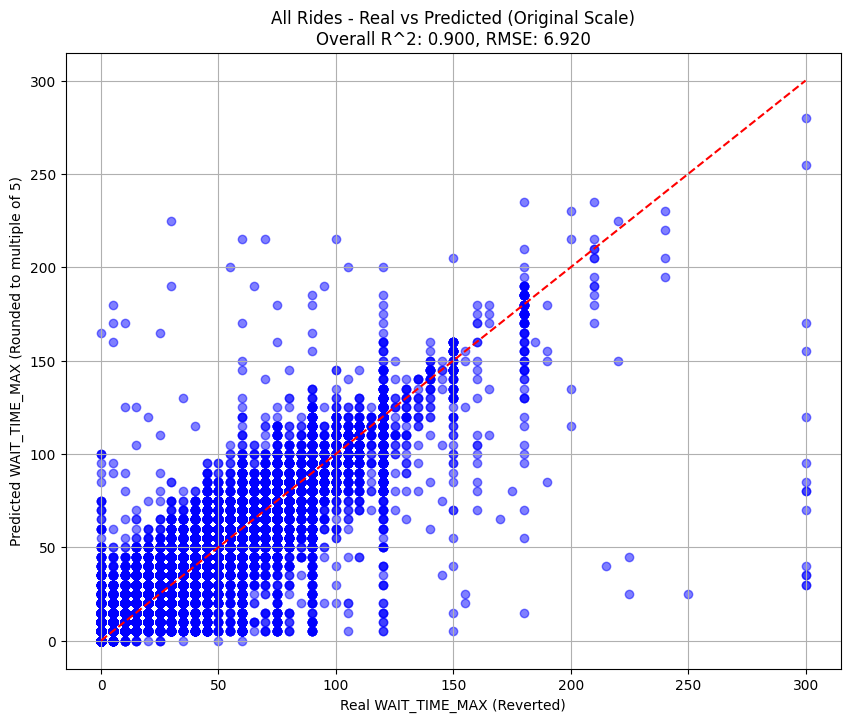

In [380]:
# ------------------------------------------------------------------------
# SCATTER PLOT (SINGLE COLOR, NO LEGEND)
# ------------------------------------------------------------------------
plt.figure(figsize=(10, 8))

# Scatter all points in blue
plt.scatter(all_y_test, all_y_pred, alpha=0.5, color='blue')

# Reference line
min_val = min(all_y_test.min(), all_y_pred.min())
max_val = max(all_y_test.max(), all_y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel("Real WAIT_TIME_MAX (Reverted)")
plt.ylabel("Predicted WAIT_TIME_MAX (Rounded to multiple of 5)")
plt.title("All Rides - Real vs Predicted (Original Scale)\n"
          f"Overall R^2: {r2_all:.3f}, RMSE: {rmse_all:.3f}")
plt.grid(True)
plt.show()


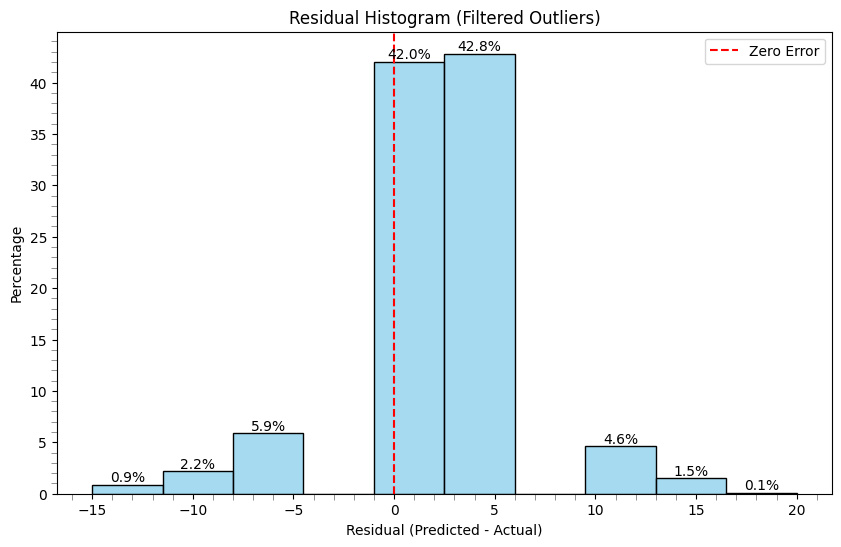

In [381]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Combine y_test and y_pred from all rides
all_y_test = np.concatenate([data["y_test"] for data in predictions_dict.values()])
all_y_pred = np.concatenate([data["y_pred"] for data in predictions_dict.values()])

# Compute residuals
residuals = all_y_pred - all_y_test

# Define outlier thresholds, e.g., 1st and 99th percentiles
lower_bound = np.percentile(residuals, 1)
upper_bound = np.percentile(residuals, 99)

# Filter outliers
residuals_filtered = residuals[(residuals >= lower_bound) & (residuals <= upper_bound)]

plt.figure(figsize=(10, 6))
# Use stat="percent" and turn off kde
ax = sns.histplot(residuals_filtered, bins=10, kde=False, stat="percent", color='skyblue')
plt.title("Residual Histogram (Filtered Outliers)")
plt.xlabel("Residual (Predicted - Actual)")
plt.ylabel("Percentage")
plt.axvline(0, color='red', linestyle='--', label="Zero Error")
plt.legend()

# Annotate each bar with the percentage value
for patch in ax.patches:
    x = patch.get_x() + patch.get_width() / 2
    y = patch.get_height()
    if y > 0:
        ax.text(x, y, f"{y:.1f}%", ha="center", va="bottom", fontsize=10)

# Enable minor ticks
plt.minorticks_on()

# Option 1: Use default minor ticks (often AutoMinorLocator does a good job)
# Option 2: Customize tick locators (for example, set minor ticks every 2 units on x-axis)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))  # 5 minor ticks between major ticks
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))

# Optionally, customize tick parameters
plt.tick_params(axis='both', which='minor', length=4, color='gray')

plt.show()


In [ ]:
# Suppose you have a new_data DataFrame, preprocessed the same way as df
new_data_preds = pd.Series(index=new_data.index, dtype=float)

for ride_name, xgb_model in models_per_ride.items():
    mask = new_data[ride_name] == 1
    X_new = new_data.loc[mask].drop(columns=ride_columns + ["WAIT_TIME_MAX"], errors="ignore")
    if len(X_new) > 0:
        new_data_preds.loc[mask] = xgb_model.predict(X_new)

# Now new_data_preds contains predictions for each row


# Load future data and make predictions

In [490]:
# Load the future data on which we cant to predict the waiting times

X_future = pd.read_csv("final_data/data_future.csv")

### Encoding the future data

In [491]:
X_future["date"] = pd.to_datetime(X_future["date"])

# Create a continuous time feature
X_future["time_encoded"] = X_future["hour"] * 4 + X_future["minute"] / 15

# Cyclical encoding for day of week
X_future["day_of_week"] = X_future["date"].dt.dayofweek
X_future["day_of_week_sin"] = np.sin(
    2 * np.pi * X_future["day_of_week"] / 7
)
X_future["day_of_week_cos"] = np.cos(
    2 * np.pi * X_future["day_of_week"] / 7
)


X_future["year"] = X_future["date"].dt.year
X_future["month"] = X_future["date"].dt.month
X_future["day"] = X_future["date"].dt.day

# Cyclical encoding for month of year
X_future["month_sin"] = np.sin(2 * np.pi * (X_future["month"] - 1) / 12)
X_future["month_cos"] = np.cos(2 * np.pi * (X_future["month"] - 1) / 12)

# Cyclical encoding for day of month
X_future["day_sin"] = np.sin(2 * np.pi * (X_future["day"] - 1) / 31)
X_future["day_cos"] = np.cos(2 * np.pi * (X_future["day"] - 1) / 31)

# Year as one-hot encoding
X_future = pd.get_dummies(X_future, columns=["year"])

# List of expected dummy columns
expected_years = ['year_2018', 'year_2019', 'year_2020', 'year_2021']

# Add any missing year columns with a default value of 0
for col in expected_years:
    if col not in X_future.columns:
        X_future[col] = 0

# Remove original columns used for encoding
X_future.drop(columns=["hour", "minute", "day_of_week", "month", "day"], inplace=True)

# One-hot encoding for ride names
ride_names = X_future["ENTITY_DESCRIPTION_SHORT"].unique()
ride_names_encoded = pd.get_dummies(X_future["ENTITY_DESCRIPTION_SHORT"])
X_future = pd.concat([X_future, ride_names_encoded], axis=1)

In [492]:
# Adding predicted attendance
pred_attendance = pd.read_csv("final_data/predicted_future_attendance_august.csv", parse_dates=["date"])

pred_attendance["attendance"] = pred_attendance["ets_forecast"]

X_future = pd.merge(X_future, pred_attendance[["date", "attendance"]], on="date", how="left")

In [493]:
# Only keep rows without downtime
X_future = X_future[X_future["DOWNTIME"] == 0]

# Drop columns not useful for the ML model
cols_to_drop = [
    "WORK_DATE",
    "FIN_TIME",
    "NB_UNITS",
    "GUEST_CARRIED",
    "NB_MAX_UNIT",
    "ADJUST_CAPACITY",
    "OPEN_TIME",
    "UP_TIME",
    "CAPACITY",
    "DOWNTIME",
    "ENTITY_DESCRIPTION_SHORT",
    "DEB_TIME",
    "DEB_TIME_HOUR",
    "FACILITY_NAME",
    "date"
]
X_future.drop(
    columns=[c for c in cols_to_drop if c in X_future.columns],
    inplace=True
)

# reorder columns
X_future = X_future[X_train.columns]

In [501]:
y_future_pred = np.expm1(best_pipeline.predict(X_future))

y_future_pred = np.where(y_future_pred < 0, 0, y_future_pred)
y_future_pred_rounded = np.floor(y_future_pred / 5) * 5 # to follow the format of the training data
future_preds = X_future.copy()
future_preds.rename(columns={"attendance": "pred_attendance"}, inplace=True)
future_preds["Predicted_WAIT_TIME_MAX"] = y_future_pred_rounded
future_preds.head()

,temp,humidity,wind_speed,clouds_all,rain_1h,snow_1h,pred_attendance,in_night_show,in_parade_1,in_parade_2,...,Rapids Ride,Roller Coaster,Spinning Coaster,Spiral Slide,Superman Ride,Swing Ride,Vertical Drop,Water Ride,Zipline,Predicted_WAIT_TIME_MAX
0,21.48,80,2.23,99,0.0,0.0,44942.371446,False,False,False,...,False,False,False,False,False,False,False,False,False,0.0
1,26.44,52,2.00,48,0.0,0.0,44942.371446,False,True,False,...,False,False,False,False,False,False,False,False,False,10.0
2,26.08,59,2.37,99,0.0,0.0,44942.371446,False,False,False,...,False,False,False,False,False,False,False,True,False,30.0
3,24.98,64,1.19,30,0.0,0.0,44942.371446,False,False,False,...,False,False,False,False,False,False,False,False,False,5.0
4,24.47,62,2.35,100,0.0,0.0,44942.371446,False,False,False,...,False,False,False,False,False,False,False,False,False,15.0


In [502]:
# ---- Decode the time from time_encoded ----
# Assuming time_encoded = hour * 4 + (minute/15)
future_preds["decoded_hour"] = (future_preds["time_encoded"] // 4).astype(int)
future_preds["decoded_minute"] = ((future_preds["time_encoded"] % 4) * 15).astype(int)

# ---- Decode the year from one-hot encoded columns ----
year_cols = ["year_2018", "year_2019", "year_2020", "year_2021", "year_2022"]

def decode_year(row):
    # Find the year column with value 1
    for col in year_cols:
        if row[col] == 1:
            return int(col.split('_')[1])
    return np.nan

future_preds["decoded_year"] = future_preds.apply(decode_year, axis=1)

# ---- Decode the month from month_sin and month_cos ----
def decode_month(row):
    theta = np.arctan2(row["month_sin"], row["month_cos"])
    # Convert negative angle to positive [0, 2pi)
    if theta < 0:
        theta += 2 * np.pi
    # (month - 1) = theta * 12 / (2*pi)
    month_est = int(round(theta * 12 / (2 * np.pi))) + 1
    # Ensure month is within 1 to 12:
    if month_est < 1:
        month_est = 1
    elif month_est > 12:
        month_est = 12
    return month_est

future_preds["decoded_month"] = future_preds.apply(decode_month, axis=1)

# ---- Decode the day from day_sin and day_cos ----
def decode_day(row):
    theta = np.arctan2(row["day_sin"], row["day_cos"])
    if theta < 0:
        theta += 2 * np.pi
    # (day - 1) = theta * 31 / (2*pi)
    day_est = int(round(theta * 31 / (2 * np.pi))) + 1
    # Ensure day is within 1 to 31:
    if day_est < 1:
        day_est = 1
    elif day_est > 31:
        day_est = 31
    return day_est

future_preds["decoded_day"] = future_preds.apply(decode_day, axis=1)

# ---- Combine decoded year, month, day, hour, minute into a datetime ----
# First, create a string in the format "YYYY-MM-DD HH:MM:SS"
future_preds["decoded_datetime_str"] = (
    future_preds["decoded_year"].astype(str) + "-" +
    future_preds["decoded_month"].astype(str).str.zfill(2) + "-" +
    future_preds["decoded_day"].astype(str).str.zfill(2) + " " +
    future_preds["decoded_hour"].astype(str).str.zfill(2) + ":" +
    future_preds["decoded_minute"].astype(str).str.zfill(2) + ":00"
)

# Convert the string column to an actual datetime
future_preds["date"] = pd.to_datetime(future_preds["decoded_datetime_str"], errors='coerce')

# Drop the columns used for decoding
future_preds.drop(columns=['time_encoded', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'year_2018',
       'year_2019', 'year_2020', 'year_2021', 'year_2022', "decoded_hour", "decoded_minute", "decoded_year", "decoded_month", "decoded_day", "decoded_datetime_str"], inplace=True)


In [503]:
# Decode the one-hot encoded ride names
ride_cols = list(ride_names_encoded.columns)

# Now create a new column that decodes the ride name by taking the column name with the maximum value along the ride columns.
future_preds["ENTITY_DESCRIPTION_SHORT"] = future_preds[ride_cols].idxmax(axis=1)

# Drop the one-hot encoded ride columns
future_preds.drop(columns=ride_cols, inplace=True)

In [504]:
future_preds.columns

Index(['temp', 'humidity', 'wind_speed', 'clouds_all', 'rain_1h', 'snow_1h',
       'pred_attendance', 'in_night_show', 'in_parade_1', 'in_parade_2',
       'covid', 'Predicted_WAIT_TIME_MAX', 'date', 'ENTITY_DESCRIPTION_SHORT'],
      dtype='object')

In [ ]:
#Drop unneded columns
future_preds.drop(columns=['temp', 'humidity', 'wind_speed', 'clouds_all', 'rain_1h', 'snow_1h', 'in_night_show', 'in_parade_1', 'in_parade_2',
       'covid'], inplace=True)
future_preds

In [ ]:
# Adding estimated intra-day pred_attendance
import numpy as np
import pandas as pd
from scipy.stats import skewnorm

def compute_day_pred_attendance(group, min_pred_attendance=1000):
    """
    For a group (i.e. one day) of future_preds, compute an estimated pred_attendance curve
    from the earliest timestamp (in hours) to the latest timestamp, then interpolate 
    the estimated pred_attendance for each row.
    """
    # Assume that the maximum pred_attendance for the day is given in the "pred_attendance" column.
    # (We assume it's constant within the day, so we take the first value.)
    max_att = group["pred_attendance"].iloc[0]
    
    # Compute the time of day as a decimal hour for each row.
    # For example, 20:30 becomes 20.5.
    times_day = group["date"].dt.hour + group["date"].dt.minute / 60.0
    
    # Determine the boundaries for the day (from first timestamp to last timestamp)
    day_start = times_day.min()
    day_end = times_day.max()
    
    # Create a time grid covering the day at 15-minute intervals.
    # Multiply the difference in hours by 4 (since 4 intervals per hour), then add 1.
    n_intervals = int((day_end - day_start) * 4) + 1
    times_grid = np.linspace(day_start, day_end, n_intervals)
    
    # Build the pred_attendance curve on the time grid:
    # 1. A logarithmic rise from the start of the day.
    log_rise = np.log(times_grid - day_start + 1)  # adding 1 to avoid log(0)
    log_rise = log_rise / log_rise.max()  # Normalize to [0,1]
    
    # 2. A skewed normal distribution to model the peak and decline.
    skewness = 3  # Positive skew (steep rise, gradual fall)
    # Place the peak at mid-day (of the current day range)
    loc = day_start + (day_end - day_start) / 2  
    # Choose a scale relative to the length of the day.
    scale = (day_end - day_start) / 4  
    skewed_dist = skewnorm.pdf(times_grid, a=skewness, loc=loc, scale=scale)
    
    # Combine the two components:
    curve = log_rise * skewed_dist
    # Normalize the curve so that its maximum is 1, then scale to the range [min_pred_attendance, max_pred_attendance].
    curve = curve / curve.max() * (max_att - min_pred_attendance) + min_pred_attendance
    
    # Now interpolate the estimated pred_attendance for each row's time of day.
    group["est_pred_attendance"] = np.interp(times_day, times_grid, curve)
    return group

# Ensure that the "date" column in future_preds is in datetime format.
future_preds["date"] = pd.to_datetime(future_preds["date"])

# Group by the date part of the "date" column (each unique day) and apply the function.
future_preds = future_preds.groupby(future_preds["date"].dt.date).apply(compute_day_pred_attendance)

# Reset index if needed (groupby might create a MultiIndex)
future_preds.reset_index(drop=True, inplace=True)


                 date  pred_attendance  est_pred_attendance
0 2022-08-01 09:30:00     44942.371446          1000.000023
1 2022-08-01 18:00:00     44942.371446         44444.964975
2 2022-08-01 15:45:00     44942.371446         23041.209668
3 2022-08-01 20:45:00     44942.371446         22968.160565
4 2022-08-01 13:15:00     44942.371446          1321.030043


In [ ]:
future_preds

In [508]:
# export predictions
future_preds.to_csv("final_data/future_predictions.csv", index=False)